In [3]:
# %pip uninstall gym-toytext
!which python

/home/andy/University/HS2022/DialogSystems/assignment2/.venv/bin/python


In [4]:
from typing import Dict, Tuple

import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from IPython import display as ipythondisplay

# Tabular Q-Learning for Blackjack (7 Points)

In this task you will implement tabular Q-learning for the popular casino game [Blackjack](https://en.wikipedia.org/wiki/Blackjack).

The simplified version of Blackjack we will look at is played with an infinite deck of playing cards. The goal of the player (your agent) is to get the sum of the value of the cards in their hand to be higher than the dealer's hand without exceeding 21 (which would result in an immediate loss).

* Numerical cards (2 - 9) have the value of the number on the card
* Face cards (Jack, Queen, King) are worth 10 points
* Aces count either as 11 or as 1

The game starts out with the player getting 2 open (face-up) cards. The dealer has 1 open card and 1 hidden (face-down) card. Each round the player can choose to either get another card ("hit") or end the round ("stick"). A round automatically ends if their hand exceeds 21.

Aces are counted either as 11 or 1. It is counted as 11 as long as the hand does not exceed 21. In that case we call the ace "usable". Otherwise the Ace is "not usable" and counted as 1.

In our case the observable state of the system consists of:
* the player's hand, which can be broken down into:
  - The total value of their hand
  - whether they have a usable Ace
* the dealer's revealed card

While the dealer's hidden card is also part of the overall state of the game, and the rules of the game are deterministic, we model this as part of the stochasticity of the Markov Decision Process. 

The actions our agent can take are to "hit" or "stick".

The agent will receive a reward of:
* 1 if it won the game
* -1 if it lost the game
* 0 for a draw
* 0 for transistions that don't end the game

One game of Blackjack corresponds to one episode.

Have a look [here](https://gymnasium.farama.org/environments/toy_text/blackjack/) for more information.

## Tabular Q-Learning

Since we have a small, finite, enumerable number of states and actions, we can use a big lookup table for the Action Value Function $Q$.

Your task is to use the Q-learning algorithm to find an optimal action value function $Q$.

Below, you can see pseudo-code for Q-learning from [Sutton and Barto (2020)](http://incompleteideas.net/book/RLbook2020.pdf), Chapter 6.5.

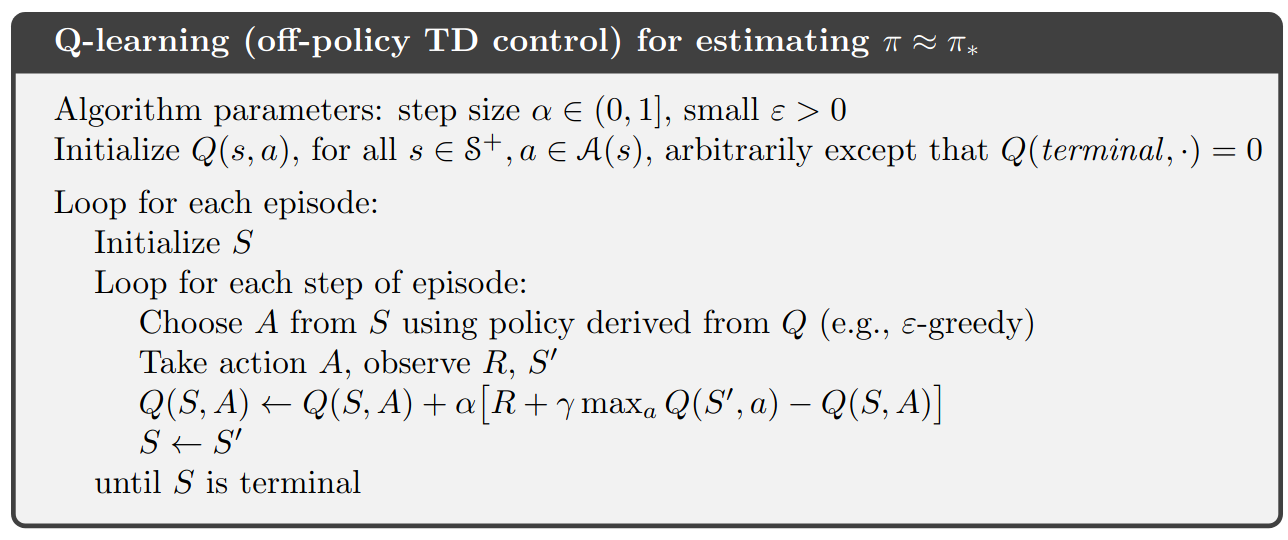

### Starting Point

Below we provide some code to get you started. We will mark where you will have to fill in specific implementation details of the Q-learning algorithm.

Below we define some type aliases that hopefully will make the code more readable overall.

In [32]:
# A state is a triple of:
#  * player_sum : int, the sum of cards in the player's hand
#  * dealer_hand : int, the card the dealer is showing (aces are shown as 1) 
#  * usable_ace : bool, whether the player has a usable ace
State = Tuple[int, int, bool]

# Actions can be either 0 or 1
# 0 means "stick" and 1 means "hit"
Action = int
ACTIONS = [0, 1]

In the next class we provide a helper class representing the table of Q-values for storing and retrieving.

In general you could just use a dictionary (`dict`) or other kind of look-up table for this. We provide custom implementation mainly so we can also provide you with an easy way to plot and visualize the state value function and greedy policy derived from your learned Q-values.

To initialize a new table you just create an instance of `Qvalues()`:
* `qvalues = QValues()`

To look up a value $Q(S, A)$:
* `qvalues.get(state, action)`

To update a value $Q(S, A) ← v$:
* `qvalues.set(state, action, v)`

Finally, you can visualize the learned values and policy by calling `.plot`:
* `qvalues.plot()`

We will show some example plots in the next few cells.

In [33]:
class QValues:

  def __init__(self):
    self.q_values: Dict[Tuple[State, Action], float] = {}
  
  def get(self, state: State, action: Action) -> float:
    """
    Q(S, A)
    return the value of Q at (state, action), will return 0 for never before seen
    pairs of states and values 
    (this bascially means that we implicitely initialize Q(s, a) = 0 for all s, a)
    """
    return self.q_values.get((state, action), 0.)

  def set(self, state: State, action: Action, new_q: float) -> None:
    """
    Q(S, A) <- new value
    assigns new_q as the action value Q for the pair (state, action)
    """
    self.q_values[(state, action)] = new_q

  def __grids(self):
    """
    taken from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/

    computes the value function V and the greedy policy derived from our 
    Q function for each possible state

    this is a helper method that will be called by the .plot method 
    
    /!\ you do not have to read or understand this
    """
    
    value_fun = {}
    greedy_policy = {}
    for (state, _) in self.q_values.keys():
      value_fun[state] = max(self.get(state, a) for a in ACTIONS)
      greedy_policy[state] = max(ACTIONS, key=lambda a: self.get(state, a))

    X, Y = np.meshgrid(
        np.arange(4, 22),
        np.arange(1, 11),
    )

    Z_usable_ace = np.apply_along_axis(
        lambda obs: value_fun.get((obs[0], obs[1], True), 0.),
        axis=2,
        arr=np.dstack([X, Y])
    )
    
    Z_no_usable_ace = np.apply_along_axis(
        lambda obs: value_fun.get((obs[0], obs[1], False), 0.),
        axis=2,
        arr=np.dstack([X, Y])
    )

    policy_usable_ace = np.apply_along_axis(
        lambda obs: greedy_policy.get((obs[0], obs[1], True), 0),
        axis=2,
        arr=np.dstack([X, Y]),
    )
    policy_no_usable_ace = np.apply_along_axis(
        lambda obs: greedy_policy.get((obs[0], obs[1], False), 0),
        axis=2,
        arr=np.dstack([X, Y]),
    )

    return {
        'x_grid': X,
        'y_grid': Y,
        'z_usable_ace': Z_usable_ace,
        'z_no_usable_ace': Z_no_usable_ace,
        'policy_usable_ace': policy_usable_ace,
        'policy_no_usable_ace': policy_no_usable_ace,
    }

  def plot(self):
    """
    taken from: https://gymnasium.farama.org/tutorials/blackjack_tutorial/

    plot the value function V and the greedy policy derived from our 
    Q function for each possible state

    /!\ you do not have to read or understand this
    """
    
    grid_data = self.__grids()

    fig = plt.figure(figsize=(20, 20))
    fig.suptitle("Value Function and Policy based on QValues", fontsize=16)

    ax1 = fig.add_subplot(2, 2, 1, projection="3d")
    ax1.plot_surface(
        grid_data['x_grid'],
        grid_data['y_grid'],
        grid_data['z_usable_ace'],
        rstride=1, cstride=1, cmap="viridis", edgecolor="none",
    )
    ax1.set_title("State values: with Usable Ace")
    ax1.set_xlabel("Player Sum")
    ax1.set_ylabel("Dealer Hand Showing")
    ax1.zaxis.set_rotate_label(False)
    ax1.set_zlabel("Value", fontsize=14, rotation=90)
    ax1.view_init(20, 220)

    ax2 = fig.add_subplot(2, 2, 3, projection="3d")
    ax2.plot_surface(
        grid_data['x_grid'],
        grid_data['y_grid'],
        grid_data['z_no_usable_ace'],
        rstride=1, cstride=1, cmap="viridis", edgecolor="none",
    )
    ax2.set_title("State values: without Usable Ace")
    ax2.set_xlabel("Player Sum")
    ax2.set_ylabel("Dealer Hand Showing")
    ax2.zaxis.set_rotate_label(False)
    ax2.set_zlabel("Value", fontsize=14, rotation=90)
    ax2.view_init(20, 220)

    legend_data = [
        Patch(facecolor="lightgreen", edgecolor="black", label="Hit"),
        Patch(facecolor="grey", edgecolor="black", label="Stick")
    ]
    ax3 = fig.add_subplot(2, 2, 2)
    ax3 = sns.heatmap(
       grid_data['policy_usable_ace'],
       linewidth=0, annot=True, cmap="Accent_r", cbar=False, 
    )
    ax3.set_title("Policy: with Usable Ace")
    ax3.set_xlabel("Player Sum")
    ax3.set_ylabel("Dealer Hand Showing")
    ax3.set_xticklabels(range(4, 22))
    ax3.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)
    ax3.legend(handles=legend_data, bbox_to_anchor=(1.3, 1.))

    ax4 = fig.add_subplot(2, 2, 4)
    ax4 = sns.heatmap(
       grid_data['policy_no_usable_ace'],
       linewidth=0, annot=True, cmap="Accent_r", cbar=False, 
    )
    ax4.set_title("Policy: without Usable Ace")
    ax4.set_xlabel("Player Sum")
    ax4.set_ylabel("Dealer Hand Showing")
    ax4.set_xticklabels(range(4, 22))
    ax4.set_yticklabels(["A"] + list(range(2, 11)), fontsize=12)
    ax4.legend(handles=legend_data, bbox_to_anchor=(1.3, 1.))

    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.show())


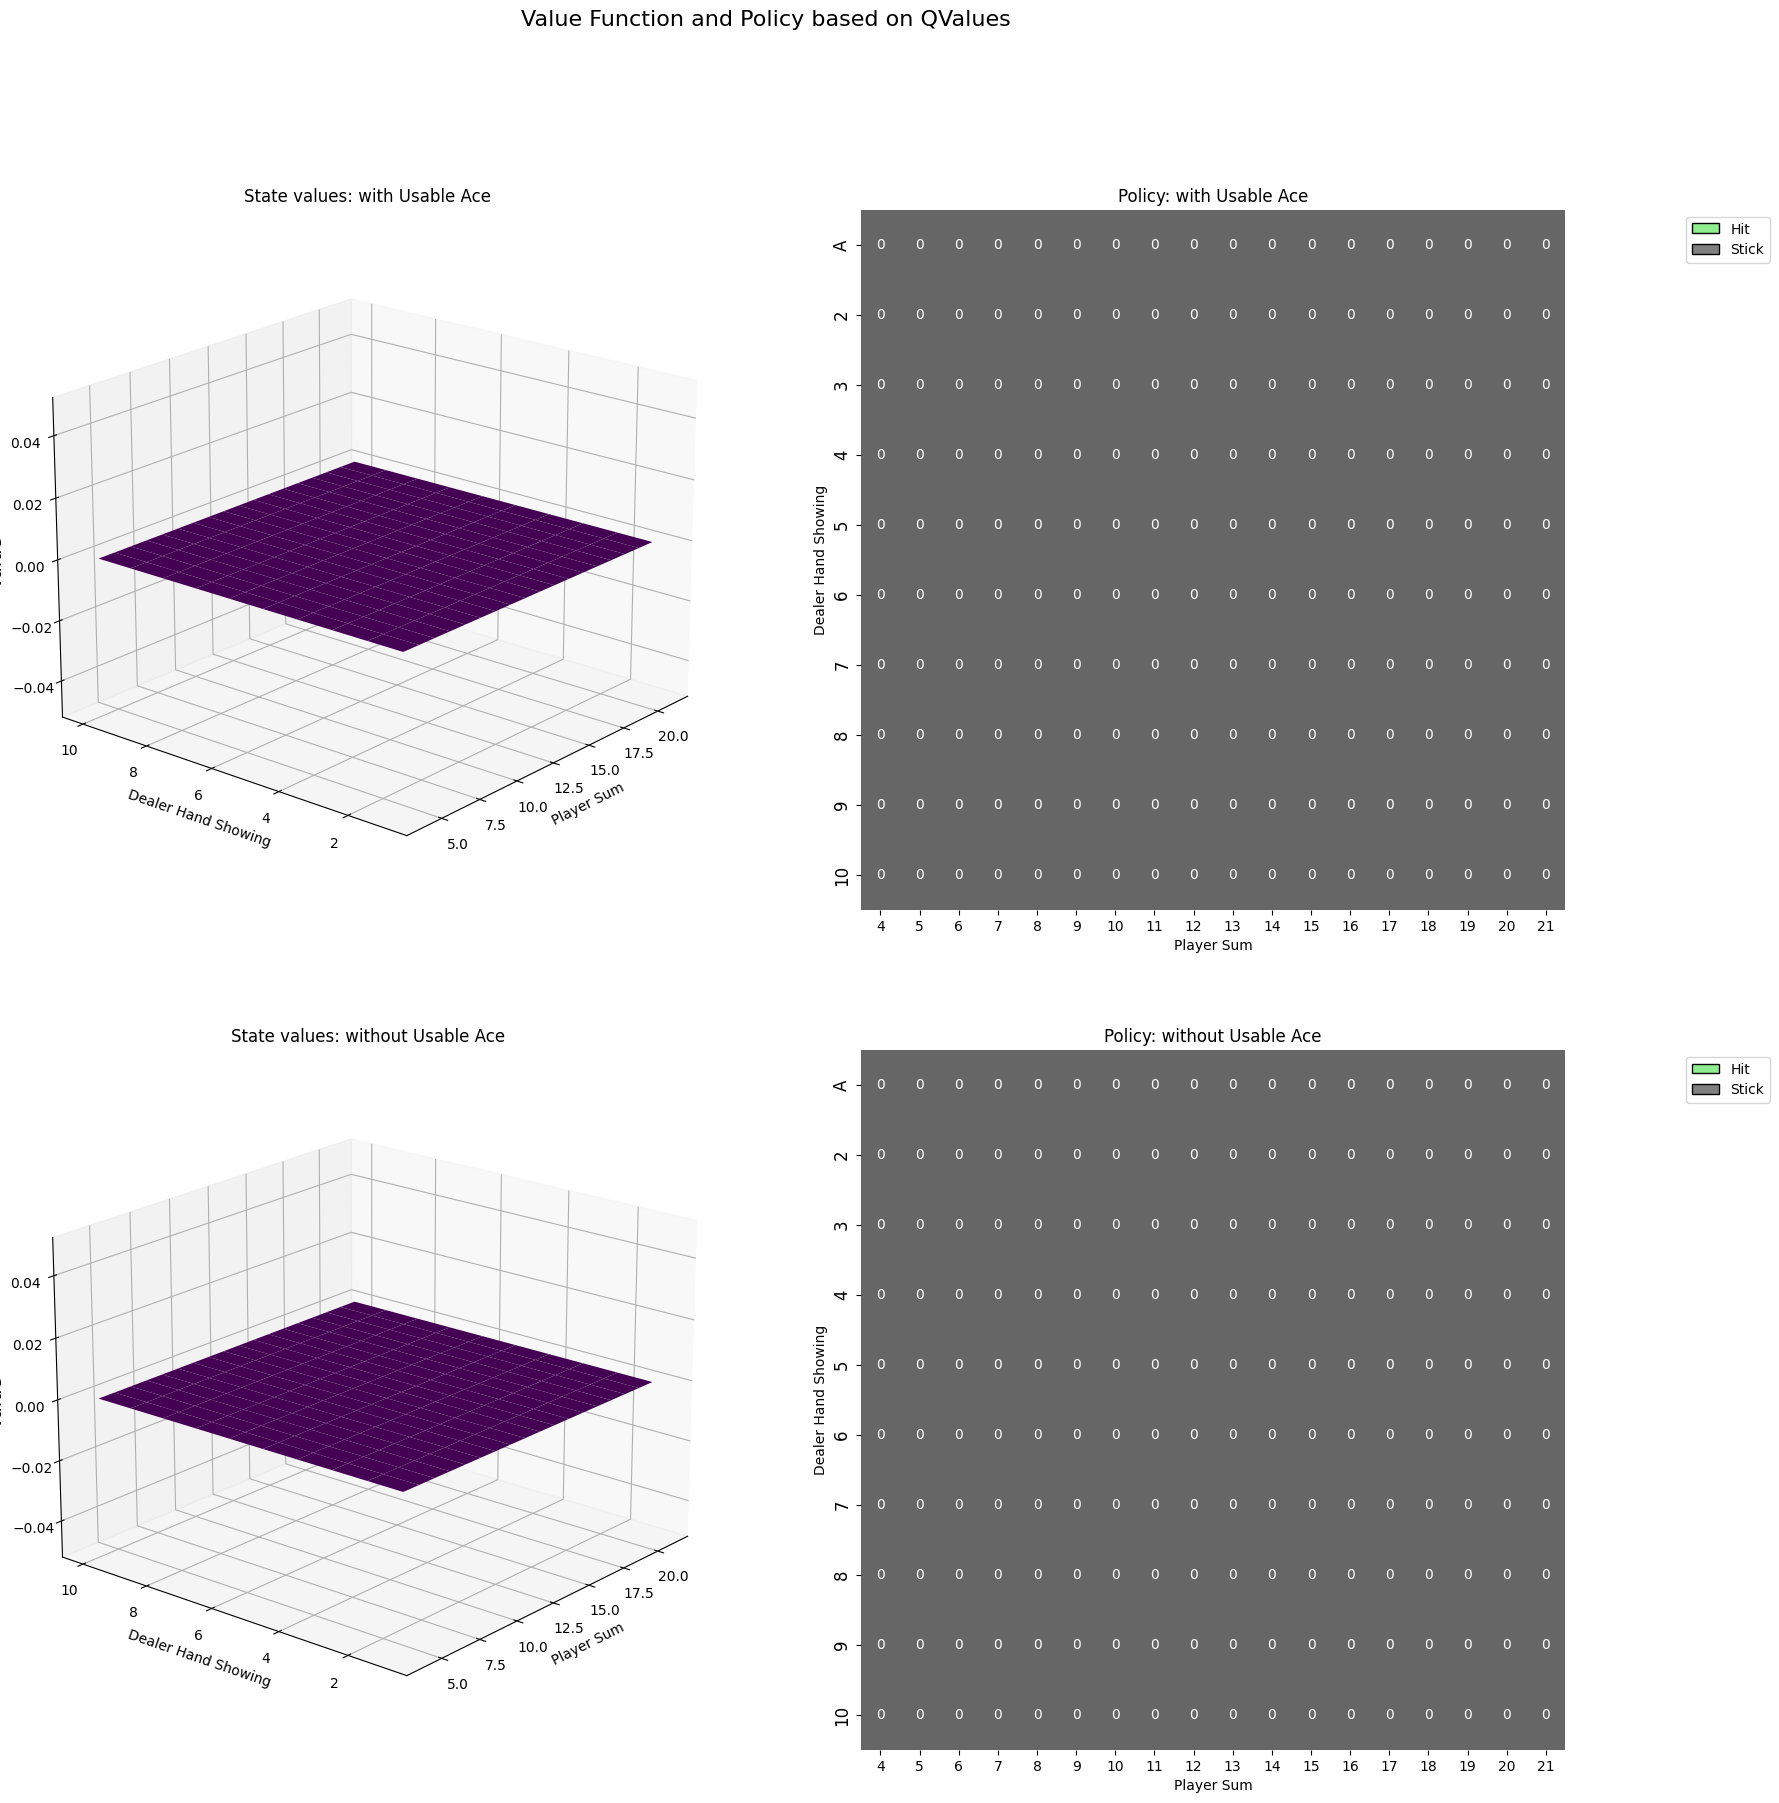

None

In [34]:
# initialize new Q-values table and plot it
QValues().plot()

The plot has 4 subplots. On the left side you see the state value functions $V$ derived from our learned $Q$ values: $V(s) = max_{a} Q(s, a)$. On the right you see the best action in each state according to our learned $Q$ values: $argmax_{a} Q(s, a)$. 

In the top 2 plots you see these for the case where the player has a usable Ace and in the bottom 2 plots where they do not.

Since we initialize all $Q$ values to $0$ implicitely, you can see that the plots aren't very interesting.

In the next cell we assign some random Q-values and plot them.

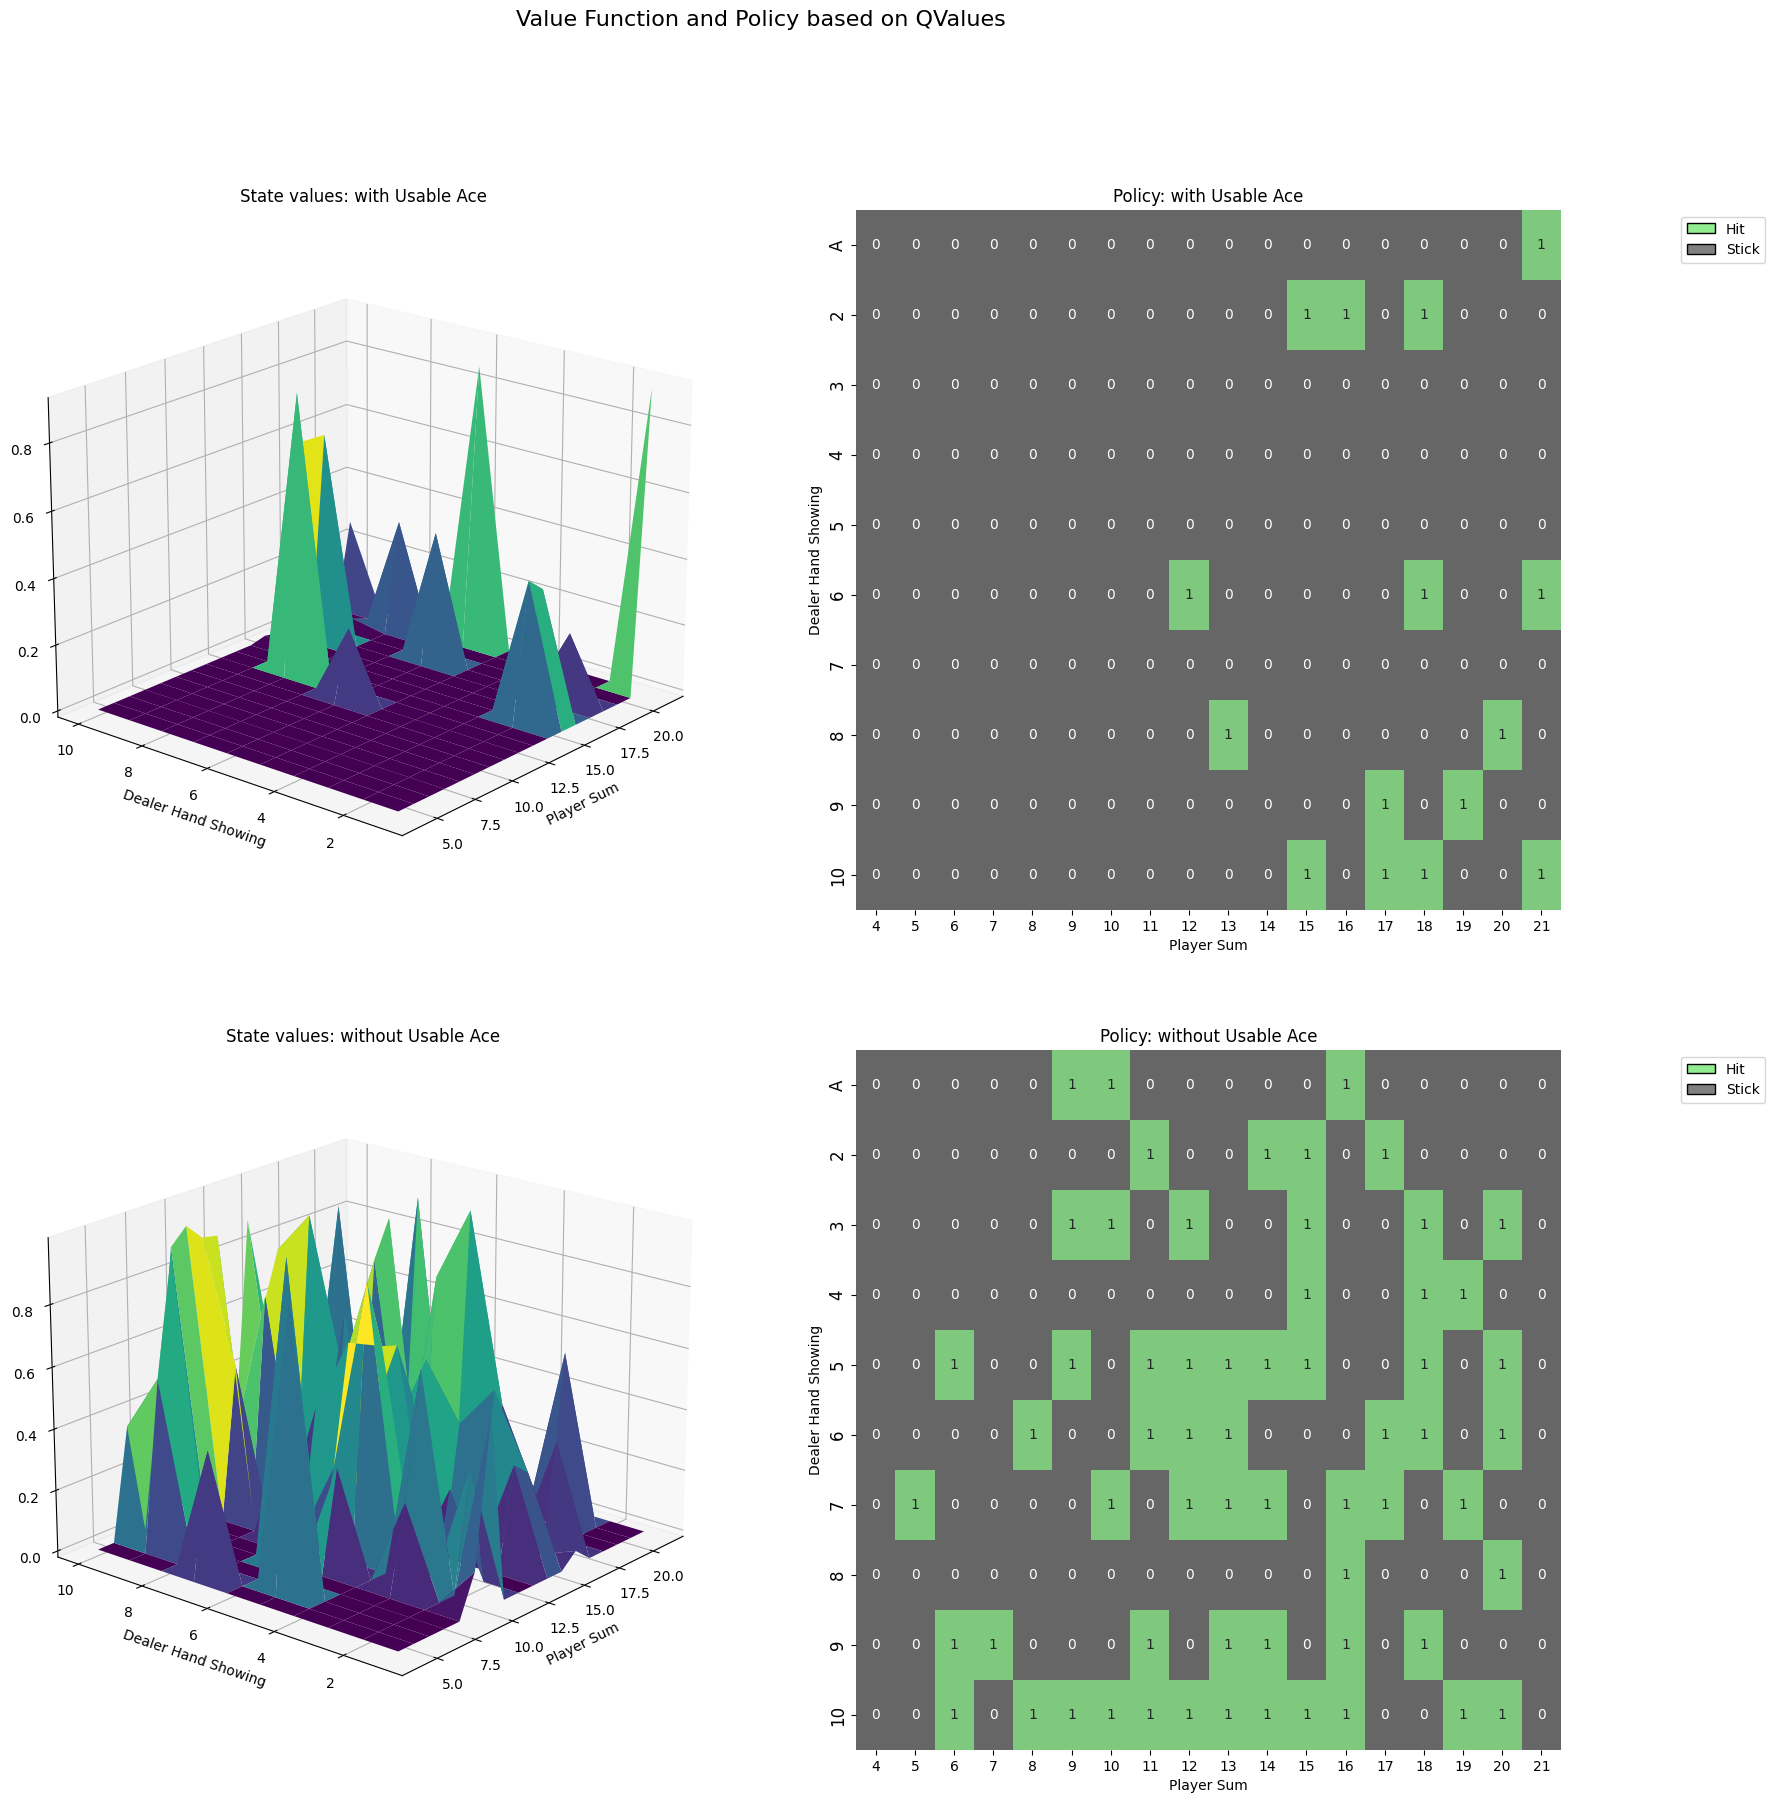

None

In [35]:
q_values = QValues()

# we will explain how to use the blackjack environment from gymnasium below
env = gym.make("Blackjack-v1", natural=False, sab=False)
for _ in range(100):
  # sample a random start state from the environment
  state, _ = env.reset()
  # we will only update the hit action
  action = 1
  # sample a random value
  value = np.random.random()
  # Q(state, action) <- value
  q_values.set(state, action, value)
env.close()

q_values.plot()

### Gymnasium

[Gymnasium](https://gymnasium.farama.org/) is a library that provides a standardized API for many common Reinforcement Learning Environments.

In the code scaffold below, we provide all the necessary calls to the gymnasium api. Here we will explain what they do:

* `env = gym.make('Blackjack-v1')` creates a new Blackjack environment. You can find the full description of this environment [here](https://gymnasium.farama.org/environments/toy_text/blackjack/).
* `env.close()` is called when you are done using the environment to clean up and free up any resources used by the environment. This is not that important for the Blackjack environment but still a good habit.
* `state, info = env.reset()` resets the environment and starts a new episode. The returned `state` corresponds to the initial state of the new episode. The `info` dictionary contains auxiliary information that we will ignore in our scaffold.
* `nxt_state, reward, terminated, truncated, info = env.step(action)` updates the environment with our agent's chosen `action`. `nxt_state` will be the state the environment moved to after our `action`. `reward` is the reward our action gained us. `terminated` tells us whether we arrived at a terminal state (end of episode). `truncated` tells us whether the episode ended without arriving at a terminal state, this is for example in certain physical environments, when our agent moves out of bounds, or an episode takes too long and times out.

### Your turn

Below you find a rough scaffold for implementing Q-learning. We will give summary of what you will have to hand in at the end of this notebook.

In [56]:
# It is probably helpful to implement a function for the epsilon-greedy policy
# with respect to your learned Q-Values
# the epsilon greedy policy will select a random action with probability epsilon
# and the greedy action (the one with the highest Q-value) 
# otherwise (probability 1 - epsilon) 
import random
def epsilon_greedy(state: State, q_values: QValues, epsilon: float) -> Action:
    """
    balance ratio between exploration and exploitation, randomly
    state:
    q_values:
    epsilon: 
    """
    rand_value = random.uniform(0,1)

    if rand_value < epsilon:
        # return either 0 or 1
        return random.randint(0, 1)
    else:
        # return either 0 or 1 based on the course of action with the 
        # most expected value
        return np.argmax([q_values.get(state,0),q_values.get(state,1)])

In [57]:
# Here we run the main Q-learning loop

# TODO: set suitable values for the different training and hyperparameters
learning_rate = 0.005  # alpha
discount = 0.65       # gamma
epsilon = 0.4
n_episodes = 100000

q_values = QValues()

env = gym.make("Blackjack-v1")

# "Loop for each episode"
for ep_ix in range(n_episodes + 1):

  # "Initialize S"
  state, _ = env.reset()
  terminal = False

  # "Loop for each step of episode"
  while not terminal:
    # "Choose A from S using policy derived from Q (e.g. epsilon-greedy)"
    action = epsilon_greedy(state,q_values,epsilon)

    # "Take action A, observe R, S'"
    nxt_state, reward, termined, truncated, _ = env.step(action)
    terminal = termined or truncated

    # here we compute max_{a} Q(S', a) (maximum value for any action in state S')
    # be aware that in Blackjack the same state can be both terminal and non-terminal
    # all terminal states should have Q-value of 0 for all actions
    if terminal:
          max_next_q = 0
    else:
          max_next_q = max([q_values.get(nxt_state,0),q_values.get(nxt_state,1)])

    
    # "Q(S, A) <- Q(S, A) + alpha*[R + gamma*max_{a}Q(S', A) - Q(S, A)]"
    cost = q_values.get(state, action) + learning_rate*(reward + discount *  max_next_q - q_values.get(state, action))
    q_values.set(state, action, cost)

    # S <- S'
    state = nxt_state

env.close()


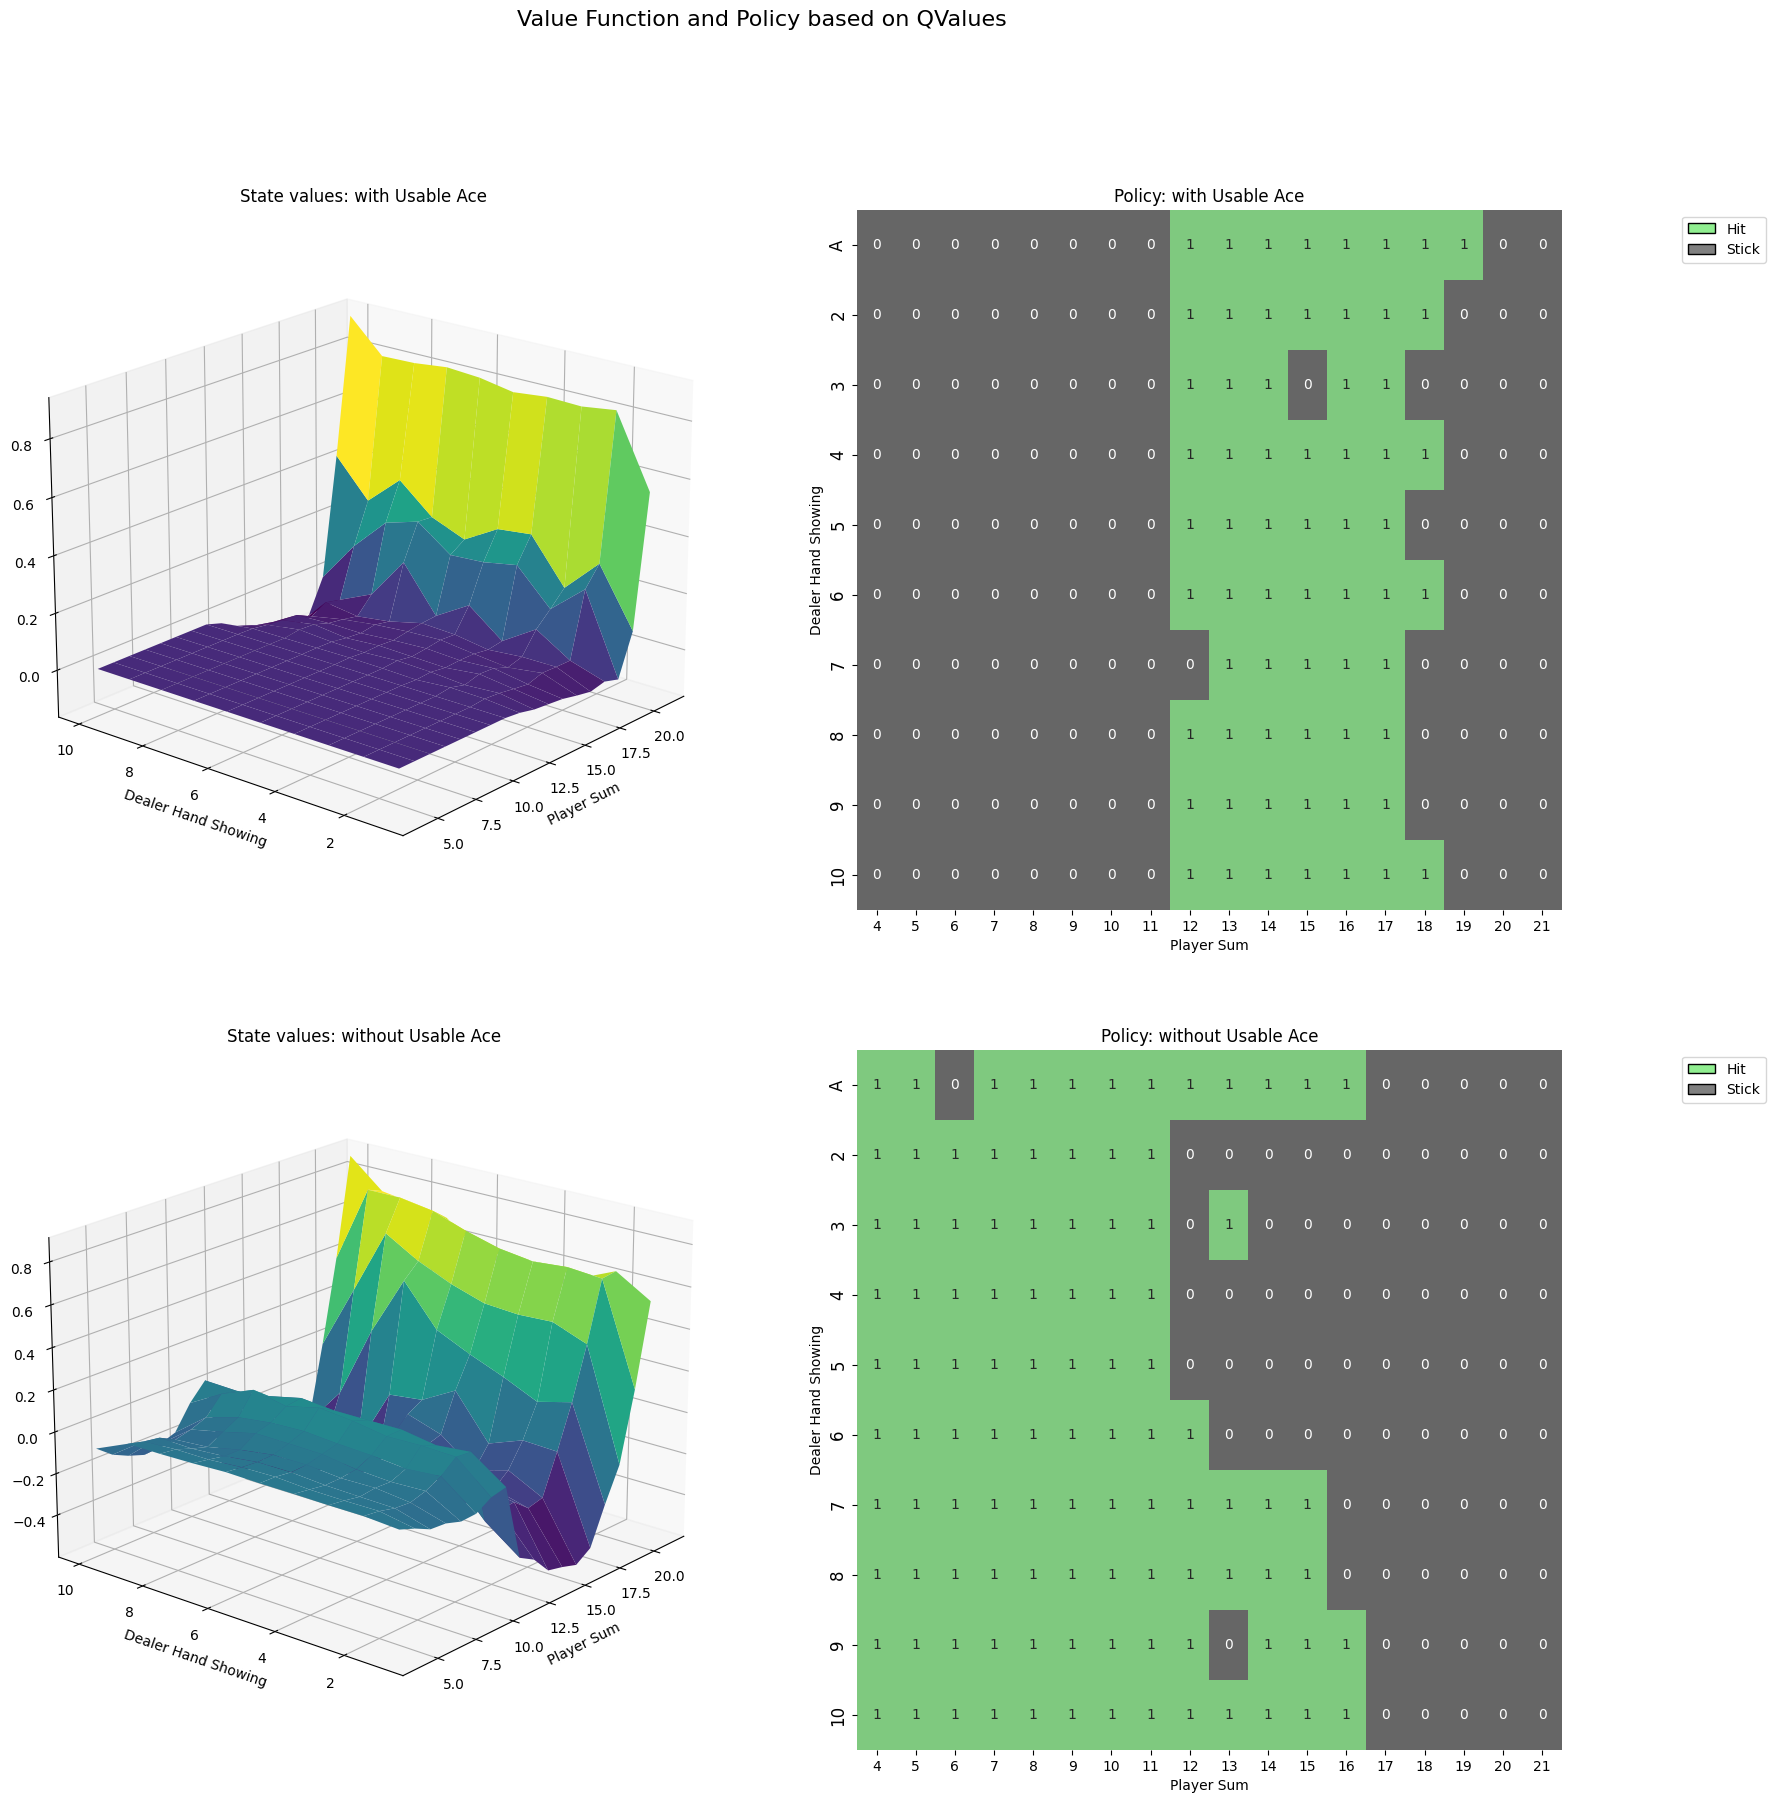

None

In [13]:
# Plot the learned Q-values (you'll have to hand these in)
q_values.plot()

In [58]:
# compute the win rate of greedy policy with respect to your Q-values
# we count a win if we transition to a terminal state and get a reward of 1.

def win_rate(qvals: QValues, n: int = 10000) -> float:
  env = gym.make("Blackjack-v1")
  
  n_wins = 0
  for _ in range(n):
    state, _ = env.reset()
    terminal = False
    while not terminal:
      # take greedy action
      action =  np.argmax([qvals.get(state,0),qvals.get(state,1)]) # TODO
      state, reward, terminal, truncated, _ = env.step(action)
      terminal = terminal or truncated

      # did we win?
      # TODO: check whether the episode ended in a win and update n_wins
    if reward==1:
      n_wins +=1
  env.close()
  
  return n_wins / n


In [59]:
win_rate(q_values)

0.4364

# Hand-In, 04.12.2022 at 23:59:59 (Zurich time, UTC + 1)

* A screenshot or copy of the cell where you implemented the main Q-learning loop
* The plot of your final Q-Values (using the provided `.plot` method)
* The win rate of your final Q-Values
* Write a couple of sentences (3-5) about how you interpret the plotted policy and value function. Do they match your intuition of Blackjack?